In [78]:
from datetime import datetime
from __future__ import division
import matplotlib.pylab as plt
import numpy as np
from numpy.linalg import cholesky
import pandas as pd
from pandas_datareader.data import DataReader
from scipy.stats import norm
%matplotlib inline

# Modeling & Quantifying Financial Risk 

This blog post looks at how we can model and quantify financial risk. It discusses concepts such as VaR, copulas and model calibration using techniques such as Maximum Likelihood.

Our approach is as follows: we first discuss the concept of maximum likelihood. This a statistical technique for parameter estimation of a distribution on a given dataset. In particular, we apply this technique to estimate the parameters of the student t distribution.

Next we consider a portfolio of assets (stocks). We model the historical data using a student t distribution

#### Maxmimum Likelihood

Maximum likelihood is a technique used to estimate parameters of a distribution which we are fitting to given a dataset $\lbrace x_i\rbrace_{i=1}^N$. Recall that when we fit a Gaussian distribution to a dataset we need to estimate two parameters: the mean and the variance. These are easily extracted from the dataset using the estimators $\hat{\mu} = \sum_{i=1}^N x_i / n$ and $\hat{\sigma}^2 = \sum_{i=1}^N (x_i - \hat{\mu})^2 / n$. These two parameters uniquely fix the Gaussian distribution fitted to the data.

However, many distributions are characterized by other parameters, which we collectively write by $\lbrace\theta_i\rbrace_{i=1}^p$ with $p$ the number of free parameters. For instance, a student t distribution has the so-called degrees of freedom parameter. Fitting a distribution to a dataset requires us to fix these parameters in a way that generates the 'best fit'. Although 'best fit' is somehwat subjective, the maxmimum likelihood is a

Given a dataset $\lbrace x_i\rbrace_{i=1}^N$ and a distribution $f(x | \theta)$ characterized by a parameter $\theta$ we construct the likelihood function as

$$ \mathcal{L}(\theta | x_1 , \ldots, x_n) = \prod_{i=1}^n f(x_i|\theta)$$

The dataset is given to us, so this expression is really only a function of $\theta$. As this parameter is varied we fit different distributions $f(\cdot | \theta)$ to the dataset. As the name suggests, the maximum likelihood fit is obtained by picking the $\theta$ which maximizes the likelihood function.

First, however, we note that the likelihood function almost always leads to a very small number. This can cause computational problem. Instead, we therefore consider the log-likelihood function given by

$$ \log \mathcal{L}(\theta | x_1 , \ldots, x_n) = \log\big(\prod_{i=1}^n f(x_i|\theta) \big) = \sum_{i=1}^n \log(f(x_i|\theta)$$

Since the logarithm is convex it will map maximum points to maximum points. So to obtain the maximum likelihood estimate of $\theta$ we can simply optimize the log-likelihood instead. It also common to consider the minus log likelihood function. Optimization corresponds to finding the minimum of this function.


If the log-likelihood function is not too complicated then we can use analytical tools to obtain the MLE of theta (maximum likelihood estimator). See for instance wikipedia for a derivation of the MLE's for a Gaussian distribution. However, for more complicated expressions we need to resort to numerical optimization techniques to optimize the LL function.

Here we use the most straightforward way of optimization (using `fmin`). We can do better using for instance explicit implementation of the first and second derivatives, but this requires knowledge of the pdf.

In [79]:
from scipy.optimize import fmin

First, we need to define two helper functions that we'll need later on..

In [80]:
def graphicalComparisonPdf(X, modelPdf, scale = True, xMin = None, xMax = None, axes_object=None, nBins=None):
    _X = X[np.logical_not(np.isnan(X))]
    if xMax is None:
        xMax = np.max(_X) # default parameter of xMax
    if xMin is None:
        xMin = np.min(_X) # default parameter of xMin
    nPlot = 1000
    xPlot = np.linspace(xMin, xMax, nPlot)
    yPlot = modelPdf(xPlot)
    if nBins is None:
        nBins = np.min([np.sqrt(X.size), 40])  
    widthHistogram          = np.max(_X)- np.min(_X)
    averageHeightHistogram  = _X.size/nBins
    areaHistogram           = widthHistogram*averageHeightHistogram
    
    pdfScaleFactor = areaHistogram if not scale else 1 
    # if scale = False we rescale modelPDF(x) by the area of the histogram
    # if scale = True the histogram is scaled, such that its area is 1 (as is the case for modelPDF(x))
    
    if axes_object is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        ax = axes_object
    
    _, _, p = ax.hist(_X, bins=nBins, normed = scale)
    l, = ax.plot(xPlot, yPlot * pdfScaleFactor, 'r', linewidth=3)
    
    ax.set_xlabel('x')
    ax.set_ylabel('pdf(x)')
    ax.set_xlim(xMin, xMax)
    if scale:
        plt.legend([l, p[0]], ['pdf(x)', 'scaled histogram'], loc='best')
    else:
        plt.legend([l, p[0]], ['scaled pdf(x)', 'histogram'], loc='best')
    return ax

In [81]:
def multivariateGaussianRand(M, mu, Sigma):
    """
    multivariateGaussianRand: Generate random numbers from a D-dimensional Gaussian
    INPUT:
         M : size of the sample
        mu : vector of means   [D,1]
     Sigma : covariance matrix [D,D]
    OUTPUT:
         Z : Sample from N(mu,Sigma) Gaussian  [M,D]  
    """
    mu = np.asarray(mu)
    Sigma = np.asarray(Sigma)
    
    D = mu.size
    
    L = cholesky(Sigma).T
    
    ## Generate M samples of D-dimensional vectors of independent Gaussians 
    X = np.random.randn(D, M)
    
    
    ## Transform vectors into vectors with proper mean and correlations
    Z = mu[:, np.newaxis] + np.dot(L, X)
    return Z.T

We define a generic handle to the minus Log Likelihood function for a given pdf. 

In [82]:
def minusLogLikelihood(pdf, X, parameters):
    """
    minusLogLikelihood: minus the likelihood of a model pdf, given the data sample X

    INPUT:
    parameters : Parameters of the model pdf
           pdf : Model pdf
             X : Sample

    OUTPUT:
           mLL : value of minus the loglikelihood, normalized by the sample size
    """
    # Compute minus the log likelihood
    return -np.sum(np.log(pdf(X, parameters)))


Then the fit function is given by

In [83]:
def fit2pdf(X, pdf, parameterseed):
    """
    Maximum likelihood fit to a PDF
    INPUT:
                  X : Sample
                pdf : Model pdf
      parameterlist : Seed for the parameters
    OUTPUT:
      logLikelihood : value of the loglikelihood
         varargaout : list of parameters that maximize the likelihood
    """

    def mLL(parameterlist):
        return minusLogLikelihood(pdf, X, parameterlist)

    varargout = fmin(mLL, parameterseed, xtol=1e-8, disp=0)

    logLikelihood = -mLL(varargout)
    return logLikelihood, varargout
    

For example, we create a dataset of 1000 samples drawn from a normal distribution, and scale this to a $N(\mu=10, \sigma=3)$ distribution. The `fit2pdf` then generates the following estimates

In [84]:
X = 3 * np.random.randn(1000) + 10
def gaussPDF(x, args):
    mu = args[0]
    sigma = args[1]
    return np.exp(-(x-mu)**2/(2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)
finalLL, param = fit2pdf(X, gaussPDF, [1, 2])
print "Estimated parameters (mu, sigma): ", param[0], ",", param[1]
print "Sample mean and variance:", X.mean(), X.std()

Estimated parameters (mu, sigma):  10.1065256191 , 2.92141020909
Sample mean and variance: 10.1065255708 2.92141024573


Sometimes the optimization procedure leads to unrealistic parameter estimates due to runaway solutions. We can therefore also use a bounded optimzation procedure using `fminbound`. In SciPy this particular implementation can only handle scalar functions. 

In [85]:
from scipy.optimize import fminbound

def fit2pdf_con(X, pdf, lb, ub):
    """
    fit2pdf_con: ML fit to a pdf, considering lower and upper bound constraints

    INPUT:
                 X : Sample
               pdf : Model pdf
                lb : lower bound constraints for the parameters
                ub : upper bound constraints for the parameters

    OUTPUT:
     logLikelihood : value of the loglikelihood
        varargaout : list of parameters than maximize the likelihood
    """
    
    def mLL(parameterlist):
        return minusLogLikelihood(pdf, X, parameterlist)

    varargout = fminbound(mLL, lb, ub, xtol=1e-8, disp=0)

    logLikelihood = -mLL(varargout)
    return logLikelihood, varargout

In [86]:
X = np.random.randn(1000) + 10
def gaussPDF2(x, mu):
    sigma = 1
    return np.exp(-(x-mu)**2/(2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)


finalLL, param = fit2pdf_con(X, gaussPDF2, 0, 15)
print "Estimated parameter mu:", param
print "True mean:", X.mean()

Estimated parameter mu: 10.0522986126
True mean: 10.0522986126


Example: GOOGLE stock

Consider now the log returns of the Google stock. In week 1 we already saw that a simply, but primitive fit of the log returns is generated by the normal distribution. We show this result here using the MLE method.

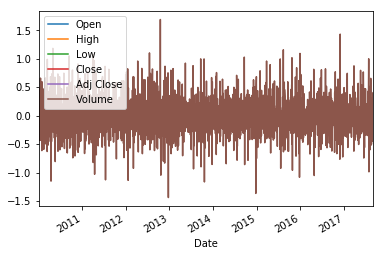

In [52]:
S = pdr.get_data_yahoo('GOOGL')
logReturn = np.log(S / S.shift(1))
logReturn.dropna(inplace=True)
logReturn.plot()

The PDF we use is the normal distribution

In [53]:
def gaussPDF(x, args):
    mu, sigma = args     
    return np.exp(-(x-mu)**2/(2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)

Next, we obtain the MLE and compare it to the sample estimates of the mean and standard deviation. For the Gaussian the parameters mu and sigma coincide with the sample mean and standard deviation, so we should obtain the same values. We use then use the graphicalComparisonPdf function to estimate the goodness of our fit.

In [54]:
def fitReturns():
    LL, (mu, sigma) =  fit2pdf(logReturn, gaussPDF, [0, 1])
    print "Estimated parameters:", mu, sigma
    print "Sample estimates:", logReturn.mean(), logReturn.std()
    
    def modelPDF(x):
        return gaussPDF(x, (mu, sigma))
    graphicalComparisonPdf(logReturn, modelPDF)
fitReturns()

ValueError: setting an array element with a sequence.

#### Student-t distribution

From the above fit we notice that the normal distribution does not produce high quality fits of stock data. In particular, it underestimates the tail events. Here we take a look at the student t distribution as an alternative model.

We first define some handles to the distribution.

In [55]:
from scipy.stats import t as tdist

## Define the 

def locationScaleTcdf(x, mu, sigma, nu):
    return tdist.cdf((x - mu)/sigma, nu)


def locationScaleTinv(p, mu, sigma, nu):
    return mu + sigma * tdist.ppf(p, nu)

def locationScaleTpdf(x, mu, sigma, nu):
    return tdist.pdf((x - mu)/sigma, nu) / sigma

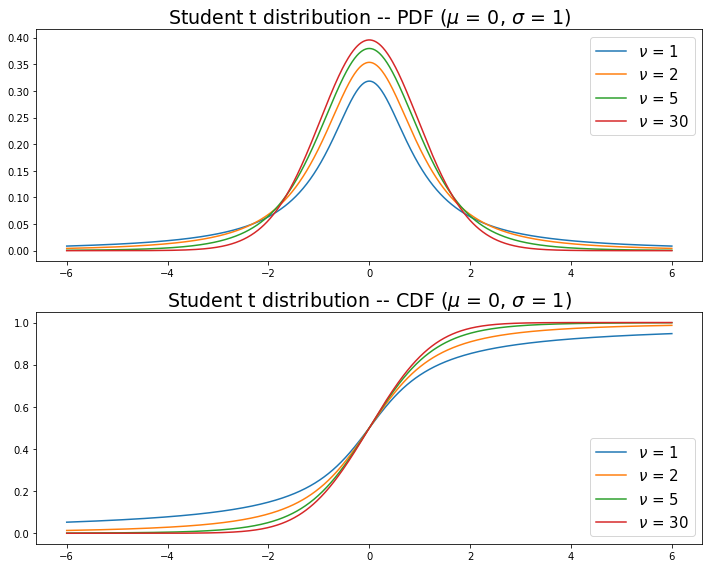

In [56]:
def demo_studentT():
    mu = 0
    sigma = 1
    nu = [1, 2, 5, 30]
    alpha = 6 
    xMin = mu - alpha * sigma
    xMax = mu + alpha * sigma
    nPlot = 1000
    xPlot = np.linspace(xMin, xMax, nPlot)
    fig = plt.figure(figsize=(10,8))
    ax_pdf = fig.add_subplot(211)
    ax_cdf = fig.add_subplot(212)
    for n in nu:
        ax_pdf.plot(xPlot, locationScaleTpdf(xPlot, mu, sigma, n), label=r'$\nu$ = {}'.format(n))
        ax_cdf.plot(xPlot, locationScaleTcdf(xPlot, mu, sigma, n), label=r'$\nu$ = {}'.format(n))
    ax_pdf.set_title('Student t distribution -- PDF ($\mu$ = {}, $\sigma$ = {})'.format(mu,sigma), fontsize=19)
    ax_pdf.legend(fontsize=15)
    ax_cdf.set_title('Student t distribution -- CDF ($\mu$ = {}, $\sigma$ = {})'.format(mu,sigma), fontsize=19)
    ax_cdf.legend(fontsize=15, loc='lower right')
    fig.tight_layout()
demo_studentT()

Next we write a function which fits the student t distribution to a dataset, using moment estimates for the mean and standard deviation as input.

In [57]:
def fit2StudentT(X, nu0):
    """
    fit2StudentT: ML fit to a Student's t distribution
    INPUT:
             X : Sample
           nu0 : Seed for the degrees of freedom

    OUTPUT:
     [mu,sigma,nu] : Parameters of the Student's t distribution from ML fit
          modelPdf : Fitted pdf
          modelPdf : Fitted cdf
          modelPdf : Fitted inv
    """

    ## Seed for mu,sigma determined from moment matching
    mu0    = np.mean(X);                        # match first moment
    sigma0 = np.sqrt(np.var(X) * (nu0 - 2)/nu0) # match second moment

    ## ML fit 
    def PDFhandle(X, args):
        _mu, _sigma, _nu = args
        return locationScaleTpdf(X, _mu, _sigma, _nu)
        
    LL, argsout = fit2pdf(X, PDFhandle, [mu0, sigma0, nu0])
    mu, sigma, nu = argsout
    
    ## Model pdf, cdf and inv
    modelPdf = lambda x: locationScaleTpdf(x, mu, sigma, nu)
    modelCdf = lambda x: locationScaleTcdf(x, mu, sigma, nu)
    modelInv = lambda p: locationScaleTinv(p, mu, sigma, nu)
    return [mu, sigma, nu], modelPdf, modelCdf, modelInv

An example

In [58]:
def studentFitExample():
    mu = 3
    sigma = 2
    nu = 2.5
    M = 1e5
    ## Draw M samples
    X = mu + sigma * tdist.rvs(nu, size=(1e5))
    
    nu0 = 5
    
    mle_args, mle_pdf, mle_cdf, mle_inv = fit2StudentT(X, nu0)
    mle_mu, mle_sigma, mle_nu = mle_args
    graphicalComparisonPdf(X, mle_pdf, xMin=-15, xMax=25, nBins=1000)
    print "Estimated parameters (MLE) vs True parameters"
    print "Mean:", np.round(mle_mu, 5), mu
    print "Std: ", np.round(mle_sigma, 5), sigma
    print "DF:  ", np.round(mle_nu, 5), nu
studentFitExample()


TypeError: 'numpy.float64' object cannot be interpreted as an index

#### Copulas

Recall that in Week 8 we encountered the multivariate Gaussian distribution. These multivariate distributions are characterized by (1) the marginal distribution of the random variables which are also Gaussian, and (2) a linear correlation between the different random variables which is completely captured by the covariance matrix $\Sigma$.

The multivariate Gaussian can only deal with linear correlations among its random variables. For more complex dependencies we make use of a more sophisticated object: copulas. Using copulas we can seperate the process of (1) modelling the individual assets and (2) modeling the dependencies between these assets. For an exact definition of the copula we refer to the lecture.

Here we look at two different copulas: the Gaussian and the student t copulas. For simplicity we assume that in both cases the  marginal distributions are all Gaussians. 

We first implement a random number generator from a Gaussian copula.

In [59]:
from numpy.linalg import cholesky
from scipy.stats import norm



def gaussianCopulaRand(M, rho):
    """
    gaussianCopulaRand: Generates random numbers from a Gaussian copula
    INPUT:
         M : size of the sample
       rho : corelation matrix [D,D]

    OUTPUT:
         U : Sample from the copula [M,D]  
    """
    
    rho = np.asarray(rho)
    
    ## Dimensionality of the copula
    D = rho.shape[0]
    
    ## Cholesky decomposition
    L = cholesky(rho).T
    
    ## Sample from N(0, I)   [independent components]
    X = np.random.randn(D, M)     
    
    ## Sample from N(0, rho) [linearly dependent components]
    Z = np.dot(L, X)                          
    
    ## Gaussian copula (U[0, 1] marginals)
    U = norm.cdf(Z)   # Matrix [D, M]
    U = U.T           # Matrix [M, D]
    return U


For example

In [60]:
def exampleGaussCopula():
    rho = [[1, 0.8], [0.8, 1]]
    M = 2e3
    U = gaussianCopulaRand(M, rho)
    Uinv = norm.ppf(U).T
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(121)
    ax.scatter(Uinv[0], Uinv[1])
    ax.set_xlim(-4, 4)
    ax.set_ylim(-3, 3)
    ax.set_aspect(1)
    ax.set_title('Multivariate Gaussian', fontsize=18)
    ax2 = fig.add_subplot(122)
    ax2.scatter(U.T[0], U.T[1])
    
    ax2.set_aspect(1)
    ax2.set_xlim(0,1)
    ax2.set_ylim(0,1)
    ax2.set_title('Gaussian copula', fontsize=18)
exampleGaussCopula()

TypeError: 'float' object cannot be interpreted as an index

There is clear linear correlation between the X and Y components of the sample points. To introduce non-linear correlations using copulas we need a more sophisticated construct, for instance by using a student t distribution.

Here we implement such a coopula. To emphasize, the marginal distributions are still assumed to be Gaussians. It's the correlation among the different components which is described by the student t distribution.

In [61]:
from scipy.stats import t as tdist
from scipy.stats import chi2



def studentTCopulaRand(M, rho, nu):
    """
    studentTCopulaRand: Generates random numbers from a Student's t copula

    INPUT:
         M : size of the sample
       rho : corelation matrix [D,D]
        nu : degrees of freedom

    OUTPUT:
         U : Sample from the copula [M,D]  
%
%% EXAMPLE:   
%        rho = [1 0.8; 0.8 1];
%        M = 1e4;
%        U = studentTCopulaRand(M,rho);
%        figure(1);
%        plot(U(1,:),U(2,:),'.');
    """
    rho = np.asarray(rho)
    
    ## Dimensionality of the copula
    D = rho.shape[0] 
    
    ## Cholesky decomposition
    L = cholesky(rho).T
    
    ## Sample from N(0,I)   [independent components]
    X = np.random.randn(D, M)
    
    ## Sample from N(0,rho) [linearly dependent components]
    Z = np.dot(L, X)                       
    
    ## Sample from Chi2 with nu degrees of freedom
    xi = chi2.rvs(nu, size=M)[np.newaxis, :]
    
    ## Student t copula (U[0,1] marginals)
    U  = tdist.cdf(sqrt(nu) * Z / sqrt(xi), nu) # Matrix [D,M]
    U = U.T                                     # Matrix [M,D]
    return U


In [62]:
def exampleStudentCopula():
    rho = [[1, 0.8], [0.8, 1]]
    M = 2e3
    U = studentTCopulaRand(M, rho, 2).T
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.scatter(U[0], U[1])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect(1)
    ax.set_title('Student T Copula', fontsize=18)
exampleStudentCopula()

TypeError: 'float' object cannot be interpreted as an index

#### Fitting a copula to a portfolio

In [63]:
S = DataReader(["IBM", "GOOGL"],  "yahoo", datetime(2007,7,1), datetime(2013,6,30))['Adj Close']

/usr/local/lib/python2.7/site-packages/pandas/io/data.py:353: SymbolWarning: Failed to read symbol: 'IBM', replacing with NaN.
  'NaN.'.format(sym), SymbolWarning)
/usr/local/lib/python2.7/site-packages/pandas/io/data.py:353: SymbolWarning: Failed to read symbol: 'GOOGL', replacing with NaN.
  'NaN.'.format(sym), SymbolWarning)


RemoteDataError: No data fetched using '_get_hist_yahoo'

In [64]:
def demo_multivariateModels(portfolio):
    
    portfolioReturn = np.log(portfolio / portfolio.shift(1))
    portfolioReturn.dropna(inplace=True)
    portfolioReturn.columns = ['r_' + s  for s in portfolio.columns]
    
    ## Seed for optimization of degrees of freedom
    nu0 = 5
    
    ## Create a dataframe which stores all fitted parameters and statistical functions
    ## Note that the columns PDF, CDF and INV store functions
    modelDF = pd.DataFrame(index=portfolioReturn.columns, columns=['mean', 'sigma', 'nu', 'PDF', 'CDF', 'INV'])
    param = ['mean', 'sigma', 'nu']
    
    for s in portfolioReturn.columns:
        param_fit, modelDF.loc[s, 'PDF'], modelDF.loc[s, 'CDF'], modelDF.loc[s, 'INV'] = \
            fit2StudentT(portfolioReturn[s], nu0)
        modelDF.loc[s, param] = param_fit
    
    print "Fitted the Student T distributio to the log returns of each stock in the portfolio."
    print "Found the following parameters:"
    print modelDF[param]
    print    
    print "=" * 30
    print 
    print "Plotting PDF's fitted to asset returns"
    
    
    fig = plt.figure()
    
    nSubFigs = len(portfolioReturn.columns)
    ## Transform to U[0, 1] marginals
    ## And plot fitted PDF's
    logReturnColumns = portfolioReturn.columns
    for n, s in enumerate(logReturnColumns):
        portfolioReturn['u' + s[1:]] = modelDF.loc[s, 'CDF'](portfolioReturn[s])
        ax = fig.add_subplot(nSubFigs, 1, n+1)
        graphicalComparisonPdf(portfolioReturn[s].values, modelDF.loc[s, 'PDF'],axes_object=ax, nBins=100)
        ax.set_title('Fitted PDF to asset: ' + s)
    transformedReturnColumns = portfolioReturn.columns[len(logReturnColumns):]
    plt.tight_layout()
    plt.show()
    print
    print "=" * 30
    print
    
    print "Joint distribution of the first two assets (historic and simulated)."

    fig = plt.figure(figsize=(10,10))
    ax= fig.add_subplot(221)
    n1, n2 = portfolioReturn.columns[0], portfolioReturn.columns[1]
    print n1 + ' vs ' + n2
    print 
    print
    ax.scatter(portfolioReturn[n1], portfolioReturn[n2])
    ax.set_xlim(-.15, .15)
    ax.set_ylim(-.15, .15)
    ax.set_aspect(1)
    ax.set_title("Historic joint distribution")
        
    ## What copula best fits this joint distrubtion? 
    ## We first try the Gaussian copula, with Gaussian marginal
    M = portfolioReturn.shape[0]
    
    mu = portfolioReturn[logReturnColumns[:2]].mean()
    Sigma = portfolioReturn[logReturnColumns[:2]].cov()
    Z = multivariateGaussianRand(M, mu, Sigma)
    
    ax = fig.add_subplot(222)
    ax.scatter(Z.T[0], Z.T[1])
    ax.set_xlim(-.15, .15)
    ax.set_ylim(-.15, .15)
    ax.set_aspect(1)
    ax.set_title("Gaussian copula + Gaussian marginals")
    

    ## Next look at a Gaussian copula with student t marginals
    _inv = (norm.ppf(portfolioReturn[transformedReturnColumns[:2]]))
    _corr = np.corrcoef(_inv.T[0], _inv.T[1])
    
    # Generate from gaussian copula with implied correlation
    Z = gaussianCopulaRand(M, _corr)
    
    # Generate sample points using implied CDF inverse
    z1 = modelDF.loc[n1, 'INV'](Z.T[0])
    z2 = modelDF.loc[n2, 'INV'](Z.T[1])
    ax = fig.add_subplot(223)
    ax.scatter(z1, z2)
    ax.set_xlim(-.15, .15)
    ax.set_ylim(-.15, .15)
    ax.set_aspect(1)
    ax.set_title("Gaussian copula + Student marginals")
    
    ## The final one is a student t copula with student t marginals
    ## We did not treat the ML estimates for the parameters of the student t copula
    ## so we will use some given estimates instead
    
    rho = [[1, .55], [.55, 1]]
    nu = 2.4
    
    U = studentTCopulaRand(M, rho, nu)
    u1 = modelDF.loc[n1, 'INV'](U.T[0])
    u2 = modelDF.loc[n2, 'INV'](U.T[1])
    ax = fig.add_subplot(224)
    ax.scatter(u1, u2)
    ax.set_xlim(-.15, .15)
    ax.set_ylim(-.15, .15)
    ax.set_aspect(1)
    ax.set_title("Student copula + Student marginals")
    
    
    plt.show()

Fitted the Student T distributio to the log returns of each stock in the portfolio.
Found the following parameters:
                    mean       sigma       nu
r_Open       0.000859783    0.010331  3.93203
r_High       0.000480037   0.0082349  3.18293
r_Low         0.00100426  0.00916476  3.28763
r_Close      0.000712776  0.00989043  3.55597
r_Adj Close  0.000712776  0.00989043  3.55597
r_Volume     -0.00855215    0.298692  7.50711


Plotting PDF's fitted to asset returns


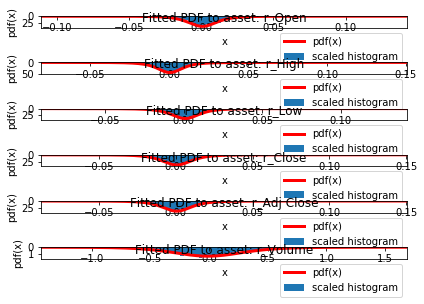



Joint distribution of the first two assets (historic and simulated).
r_Open vs r_High




NameError: global name 'sqrt' is not defined

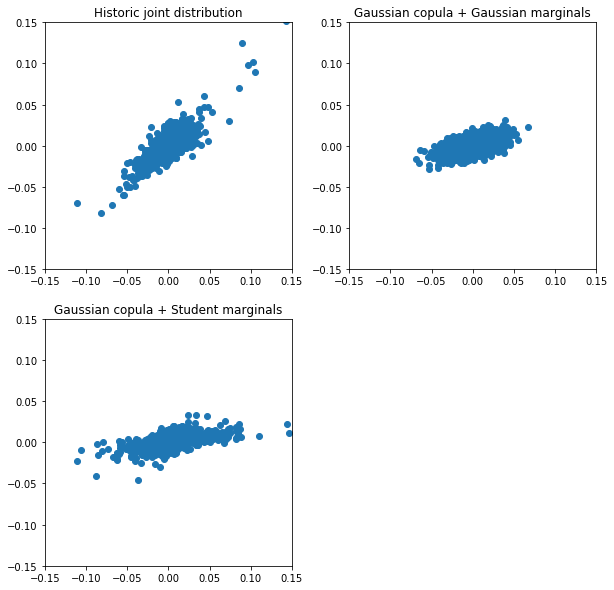

In [65]:
demo_multivariateModels(S)

A Gaussian model for the stock typically underestimates the fat tails of the asset returns. A Gaussian copula only takes into account linear correlation among the asset, which again underestimates high ''tail'' events in the joint distribution. The student t copula and student t marginals model this much better. 

#### Value-at-Risk

We finally arrive at a risk measure: the Value-at-Risk (VaR). Imagine we have some portfolio of assets. The VaR is then a method to quantify the level of financial risk of this portfolio due to e.g. changes in the market (market risk). A common definition of VaR is: what is the maximum loss of the portfolio, over a fixed timeframe, at a fixed confidence interval $\alpha$.

So suppose we have some model for the return of the portfolio. This can be based on historical data, or some assumptions on the underlying distribution of returns. Using this model we can estimate the distribution of possible returns for the portfolio over a fixed timeframe (e.g. the distribution of returns 10 days from now). The 5% VaR is then the worst possible return we can expect with 95% confidence. Put differently, it is the return that corresponds to the 5% quantile of the underlying model for that particular time horizon.

The VaR is an example of a non-coherent measure: if we have two portfolios with each its own VaR, then the VaR of the combined portfolio is in general not equal to the sum of the individual VaR (or a simple combination thereof).

A related risk measure is the Estimated Shortfall (ES). It is the average loss for losses larger larger than the VaR.

We now compute the VaR of a portfolio of stocks using two methods: Historical and Monte Carlo.

In [66]:
def simulateLossMC(logReturns, S0, priceEuroCall, priceAsianCall):
    nu0 = 5  # seed for estimating d.o.f.
    modelDF = pd.DataFrame(index=logReturns.columns, columns=['mean', 'sigma', 'nu', 
                                                              'PDF', 'CDF', 'INV'])
    # Fit student t distribution
    for n in logReturns.columns:
        params, modelDF.loc[n, 'PDF'], modelDF.loc[n, 'CDF'], modelDF.loc[n, 'INV'] = fit2StudentT(logReturns[n], nu0)
        modelDF.loc[n, ['mean', 'sigma', 'nu']] = params
        
    
    # Transform to U[0,1] marginals
    u_margin = pd.DataFrame(index=logReturns.index, columns=[], dtype=np.float)
    for n in logReturns.columns:
        u_margin[n] = modelDF.loc[n, 'CDF'](logReturns[n])
        
    # Estimate correlation for Gaussin copula
    n1, n2 = u_margin.columns[0], u_margin.columns[1]
    rho = np.corrcoef(modelDF.loc[n1, 'INV'](u_margin[n1]), modelDF.loc[n2, 'INV'](u_margin[n2]))
    
    
    # Simulation time!
    # Generate samples from estimated copula
    M = 5e4
    U = gaussianCopulaRand(M, rho)
    
    simulated_price = pd.DataFrame(index=np.arange(M), 
                             columns=logReturns.columns,
                             dtype=np.float)
    for i, n in enumerate([n1, n2]):
        simulated_price[n] = S0[n] * np.exp( modelDF.loc[n, 'INV'](U[:,i]) )
    
    # Having generated different simulations we now compute the corresponding option values
    simulated_price["IBM_call"] = priceEuroCall(simulated_price["IBM"])
    simulated_price["GOOGL_asianCallAM"] = priceEuroCall(simulated_price["IBM"])
    
    return simulated_price

In [67]:
bootstrapindices = np.random.randint(0, 10, size=10)

In [68]:
def simulateLossHistoric(logReturns, S0, priceEuroCall, priceAsianCall):
    M = 1e3
    
    bootstrapindices = np.random.randint(0, logReturns.shape[0], size=M)

    simulated_price = pd.DataFrame(index=np.arange(M), 
                             columns=logReturns.columns,
                             dtype=np.float)
    for n in logReturns.columns:
        simulated_price[n] = S0[n] * np.exp( logReturn.iloc[bootstrapindices].values )
    
    
    simulated_price["IBM_call"] = priceEuroCall(simulated_price["IBM"])
    simulated_price["GOOGL_asianCallAM"] = priceEuroCall(simulated_price["IBM"])
    return simulated_price
    

Next we will compute two risk measures of a portfolio consisting of IBM and Google stock, IBM call options and Google Asian call options (arithmetic mean). The functions to compute these options were implemented in week 8, so we will simply import them here.

To compute the risk measures we need a distribution of the expected losses (or profits) over a given time horizon. To obtain this distribution we simulate the assets in the portfolio over the given time horizon using either Monte Carlo or the historic approach. With these simulated portfolios we then compute the loss for each simulated portfolio, and from it construct a distribution of potential losses over the given time horizon. Finally, we compute the desired risk measues.

In [72]:
def priceEuropeanCall(S0, K, r, T, sigma):
    """
    Price of a European call option in the Black-Scholes model
    
    INPUT:
       S0 : Initial value of the underlying asset
        K : Strike 
        r : Risk-free interest rate 
        T : Time to expiry 
    sigma : Volatility 
    *args : extra arguments can be passed, but are not used
    OUTPUT:
    price : Price of the option in the Black-Scholes model  
    """
    
    discountedStrike = np.exp(-r * T) * K
    totalVolatility = sigma * np.sqrt(T)
    
    d_minus = np.log(S0 / discountedStrike) / totalVolatility - .5 * totalVolatility
    d_plus = d_minus + totalVolatility
    
    # The extra zero in the return is the variance in price, which is of course zero. This way the
    # function behaves similar to the Monte Carlo methods defined below which have non-zero variance
    return S0 * norm.cdf(d_plus) - discountedStrike * norm.cdf(d_minus)

In [74]:
def  priceAsianArithmeticMeanCallMC_withControlVariate(S0,K,r,T,sigma,M,N):
    """
    priceOptionMC: Black-Scholes price of a generic option providing a payoff.
    
    INPUT:
       S0 : Initial value of the underlying asset
        r : Risk-free interest rate 
        T : Time to expiry 
    sigma : Volatility 
        M : Number of simulations
        N : Number of observations
    payoff_function : payoff function of the option
    
    OUTPUT:
     price_MC : MC estimate of the price of the option in the Black-Scholes model  
     stdev_MC : MC estimate of the standard deviation  
    """
    
    ## Generate M x N samples from N(0,1)
    X = np.random.randn(M, N)

    ## Simulate M trajectories in N steps
    deltaT = T / N
    e = np.exp((r-0.5*sigma**2) * deltaT  + sigma * np.sqrt(deltaT) * X)
    S = np.cumprod(np.c_[S0 * np.ones((M,1)), e], axis=1)        
        
    def arithmeticMean(S):
        S_mean = np.mean(S[:, 1:], 1)
        return np.where(S_mean < K, 0, S_mean - K)
        
    def geometricMean(S):
        S_mean = np.exp(np.mean(np.log(S[:, 1:]), 1))
        return np.where(S_mean < K, 0, S_mean - K)    
        
        
    payoff_ar, price_ar, std_ar = priceOptionMCWithSAsInput(S, r, T, M, arithmeticMean)
    payoff_geom, price_geom, std_geom = priceOptionMCWithSAsInput(S, r, T, M, geometricMean)
    price_geom_exact = priceAsianGeometricMeanCall(S0,K,r,T,sigma,N)
    
    covarianceMatrix = np.cov(np.c_[payoff_ar, payoff_geom].T)
    
    var_ar = covarianceMatrix[0,0]
    var_geom = covarianceMatrix[1,1]
    cov_ar_geom = covarianceMatrix[0,1]
    
    corr_ar_geom = cov_ar_geom / np.sqrt(var_ar * var_geom)
    
    
    price_MC = price_ar - cov_ar_geom / var_geom * (price_geom - price_geom_exact)
    std_MC = std_ar * np.sqrt(1 - corr_ar_geom**2)
    return price_MC, std_MC

In [75]:
def constructPortfolio(N=5, horizon=5, simulateLoss='historic'):

    if simulateLoss == 'historic':
        simulateLoss = simulateLossHistoric
    else:
        simulateLoss = simulateLossMC
    S = DataReader(["IBM", "GOOGL"],  "yahoo", datetime(2007,7,1), datetime(2013,6,30))['Adj Close']
    
    ## Select data in recent past -- we don't want to test with data which is too old.
    N = 500
    
    S = S.iloc[-N:]
    S0 = S.iloc[-1]
    print "Behavior of stock over last %s days" % N
    S.plot()
    plt.show()
    ## Compute returns for specified time horizons
    # Horizon for the risk measures
    horizon = 5
    
    # Overlapping indices    
    logReturns = np.log(S / S.shift(horizon))
    logReturns.dropna(inplace=True)
    
    
    ## Portfolio of stocks and options. 
    ## portfolioComposition holds the number of assets held in the portfolio
    wghts = {"IBM"               : 500, 
             "GOOGL"             : 200,
             "IBM_call"          : 5000,
             "GOOGL_asianCallAM" : 2000}
    portfolioComposition = pd.Series(data=wghts.values(), index=wghts.keys(), dtype=np.float)
    ## portfolio will hold the value per asset in the portfolio
    portfolio = pd.Series(index=portfolioComposition.index, data=0, dtype=np.float)
    portfolio[["IBM", "GOOGL"]] = S0[["IBM", "GOOGL"]]
    
    
    ## Computing value of European call options for IBM in portfolio
    r = .01         # interest rate
    K_call = 180    # strike price
    T_call = 1      # time to maturity
    sigma_IBM_implied = .16  # Implied volatility on IBM call options
    def priceEur(S):
        return priceEuropeanCall(S, K_call, r, T_call, sigma_IBM_implied)
    portfolio["IBM_call"] = priceEur(S0["IBM"])

    ## Computing value of Asian call options with Arithmetic mean for google using a control variate
    N_AM = 6      # Number of monitoring times for the arithmetic mean 
    T_AM = .5     # Time to maturity
    M_AM = 1e3    # Number of simulated trajectories
    K_AM = 430    # Strike of the Asian arithmetic mean call option
    
    
    #
    ## !!!! K_AM should be changed to 880 if you are using this code for the homework !!!! ###
    #
    
    
    # Here we use historical volatility
    nDaysInYear = 252
    sigma_GOOG   = sqrt(nDaysInYear/horizon)*std(logReturns["GOOGL"])
    def priceAsian(S):
        return priceAsianArithmeticMeanCallMC_withControlVariate(S, K_AM, r, T_AM, sigma_GOOG, M_AM, N_AM)
    price_AM, std_AM = priceAsian(S0["GOOGL"])
    portfolio["GOOGL_asianCallAM"] = price_AM
    
    print "Current value per asset:"
    print portfolio.head()
    print
    print "Weight in portfolio:"
    print portfolioComposition.head()
    print
    
    # Next we simulate the potential returns of the portfolio using either the
    # historic method (bootstrapping of historic data)
    # Monte Carlo (Fitting a copula to historic data, and simulating new data)
    simulated_assets = simulateLoss(logReturns[["IBM", "GOOGL"]], S0, priceEur, priceAsian)
    
    print "Simulated return histograms"
    simulated_assets.hist(bins=20)
    plt.show()
    print "Corresponding simulated returns of weighted portfolio"
    simulated_portfolio = (simulated_assets * portfolioComposition).sum(axis=1)
    simulated_portfolio.hist(bins=25)
    current_portfolio = (portfolio * portfolioComposition).sum()
    plt.show()
    
    print "Simulated loss of portfolio"
    loss_simulated = (-(simulated_portfolio - current_portfolio))
    
    ## Finally, we compute the VaR at 5% and the estimated loss
    p = .95
    VaR = loss_simulated.quantile(.95)
    indexTail = loss_simulated > VaR
    ES = np.mean(loss_simulated.ix[indexTail])
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    loss_simulated.hist(bins=50, ax=ax, normed=True)
    y_lim = ax.get_ylim()
    
    ax.plot([VaR, VaR], y_lim, 'r', label='VaR 5%')
    ax.plot([ES, ES], y_lim, 'g', label='ES 5%')
    ax.legend(loc='best')
    plt.show()
    print 
    # Print out returns. VaR is the value at risk, and larger is worse.
    print "Value-at-Risk: %.2f" % VaR
    print "Expected Shortfall: %.2f" % ES

First we have the Monte Carlo approach

In [76]:
constructPortfolio(simulateLoss='MC')

RemoteDataError: No data fetched using '_get_hist_yahoo'

And now using the historic method

In [77]:
constructPortfolio(simulateLoss='historic')

RemoteDataError: No data fetched using '_get_hist_yahoo'

#### Expectation Maximizaton of Gaussian Mixtures

In the homework we are given an implementation for an algorithm which finds the maximum likelihood for models with latent variables. This particular algorithm applies to Gaussian mixture models. Here we provide the Python version for this implementation.

In [ ]:
def expectationMaximizationGM(Z, K, p=None, mu=None, sigma=None):
    """
    expectationMaximizationGM: EM algorithm for a mixture of K Gaussians GM[p,mu,sigma]


    INPUT:
         Z : Sample with M observations 
         K : Number of Gaussians in the mixture

    OPTIONAL INPUT PARAMETERS (initial seed for EM)
         p : vector of probabilitiess  [Kx1]
        mu : vector of means           [Kx1]
     sigma : vector of stdev's         [Kx1]

    OUTPUT:
         p : vector of probabilitiess  [Kx1]
        mu : vector of means           [Kx1]
     sigma : vector of stdev's         [Kx1]

%% EXAMPLE:
%
%   %% Sample matrix (M rows, N columns) 
%   M = 1000;
%   N = 1;
%   %% Gaussian components
%   p     = [ 1/2 1/3  1/6];  % probability vector 
%   mu    = [-1.0 4.0 12.0];  % means 
%   sigma = [ 1.0 3.0  0.5];  % standard deviations
%
%   %% Generate sample Z ~ GM[p,mu,sigma)
%   Z = GMrand(M,N,p,mu,sigma);
%
%   %% EM for Gaussian mixture
%   [p, mu, sigma] = expectationMaximizationGM(Z,3)
%
%   %% Compare modelPdf and scaled histogram
%   modelPdf = @(z)(GMpdf(z,p,mu,sigma));
%   figure(1); graphicalComparisonPdf(Z(:),modelPdf)
%   title('Z ~ GM[p,\mu,\sigma]')
    """
    if K == 1:
        # Fit to a single Gaussian  
        p = 1
        mu = np.mean(Z)
        sigma = np.std(Z)
        return p, mu, sigma

    if mu is None or sigma is None or p is None:
        # initialization of parameters
        mu0 = np.mean(Z)
        sigma0 = np.std(Z)
        mu = np.linspace(mu0 - 2 * sigma0, mu0 + 2 * sigma0, K)
        sigma = 2 * sigma0 * np.ones_like(mu, dtype=np.float)
        p = np.ones(K, dtype=np.float) / K
        
    p = np.asarray(p).flatten()
    sigma = np.asarray(p).flatten()
    mu = np.asarray(mu).flatten()

    Z = np.asarray(Z).flatten()  # Ensures that Z is a row vector
    M = Z.size                   # Size of the sample
    
    a, b, c, m = 0.0, 0.0, 0.0, 0.0    # standard EM
    #a, b, c, m = .2, .2, .1, .0       # Modified EM (Hamilton, 1991)

    TOL_MU = 1e-6
    TOL_SIGMA = 1e-6
    TOL_P  = 1e-6
    MAXITER = 5000
    
    ##  EM Algotrithm 
    dmu = 10 * TOL_MU
    dsigma = 10 * TOL_SIGMA
    dp = 10 * TOL_P
    nIter = 0
    
    def gt(vec, tol):
        return np.any(np.abs(vec) > tol)
    
    def weightedNormPDF(Z, mu, sigma, p):
        Zsc = (Z[np.newaxis]-mu[:, np.newaxis])/sigma[:, np.newaxis]
        return p[:, np.newaxis] * np.exp(- (Zsc**2) /2) / (np.sqrt(2*np.pi) * sigma[:, np.newaxis])
    
    while ((nIter < MAXITER) & (gt(dmu, TOL_MU) | gt(dsigma, TOL_SIGMA) | gt(dp, TOL_P))):
        # increment the iteration counter
        nIter = nIter + 1
        gamma = np.empty((K, M), dtype=np.float)
        
        
        gamma = weightedNormPDF(Z, mu, sigma, p)
        
        gNorm = gamma.sum(axis=0)
        gamma = gamma / gNorm[np.newaxis, :]
        gNorm2 = gamma.sum(axis=1)
        
        
        dp = -p
        dmu = -mu
        dsigma = -sigma
        
        
        p = gNorm2 / M
        mu = (c * m + np.dot(gamma, Z))/(c + gNorm2)
        sigma = np.sqrt((b + c * (m - mu))**2 + 
                        (gamma * (Z[np.newaxis, :] - mu[:, np.newaxis])**2).sum(axis=1) /
                        (a + gNorm2))
        
        # check how much paremeter estimates have changed
        dp = dp + p
        dsigma = dsigma + sigma
        dmu = dmu + mu
        
    if (nIter >= MAXITER):
        print 'Warning: EM for GM has not fully converged. Try a smaller number of Gaussians'

    return p,mu,sigma


In [ ]:
def categoricalRand(M, N, p):
    """
    Random number generator for categorical variables.
    
    INPUT:
    M : size of sample
    N : number of samples
    p : array of (normalized) probabilities for categorical variables
    
    OUTPUT:
    
    k : N samples of size M (MxN array) of randomly drawn categorical variables.
        k takes values between 1 and the size of p.
    
    """
    p = np.cumsum(np.r_[0, p])

    # Sample from U[0,1]
    k = np.random.rand(M,N)
    # Sample from Categorical[p,K]
    k = np.sum(k[:,:,np.newaxis] > p, axis = 2)
    return k.astype(np.int)

def GMrand(M, N, p, mu, sigma):
    """
    Random number generator for random variables drawn from a Gaussian Mixture.
    
    INPUT:
    M     : size of sample
    N     : number of samples
    p     : weight for each Gaussian
    mu    : mean for each Gaussian
    sigma : std for each Gaussian
    
    OUTPUT:
    
    Z : N samples of size M (MxN array) of randomly drawn variables from a Gaussian mixture. 
    
    """
    p  = np.asarray(p)
    mu = np.asarray(mu)
    sigma = np.asarray(sigma)
    
    xi = categoricalRand(M,N,p) - 1
    
    X  = randn(M,N)
    Z  = mu[xi] + sigma[xi] * X
    return Z

def GMpdf(x, p, mu, sigma):
    """
    Exact PDF of a Gaussian Mixture
    INPUT:
      x     : shape used for shape of output [MxN]
      p     : Probability vector  [Kx1]
      mu    : Vector of means     [Kx1]
      sigma : Vector of stdev's   [Kx1]

    OUTPUT:
      y : Value of the pdf [same size as x]  
    """
    
    # Compute pdf 
    y = np.zeros_like(x, dtype = np.float);
    for k in range(len(p)):
        y = y + p[k]*norm.pdf(x,mu[k],sigma[k])
    return y

In [ ]:
def example():
    ## Sample matrix (M rows, N columns) 
    M = 1e4;
    N = 1;
    ## Gaussian components
    p     = [ 1/2, 1/3,  1/6]   # probability vector 
    mu    = [-1.0, 4.0, 12.0]   # means 
    sigma = [ 1.0, 3.0,  0.5]   # standard deviations

    ## Generate sample Z ~ GM[p,mu,sigma)
    Z = GMrand(M,N,p,mu,sigma)

    ## EM for Gaussian mixture
    p_e, mu_e, sigma_e = expectationMaximizationGM(Z, 3)
    print "Estimated vs True parameters:"
    print "Gaussian weights: {}   {}".format(np.round(p_e,4), np.round(p, 4))
    print "Gaussian means:   {}   {}".format(np.round(mu_e,4), mu)
    print "Gaussian std:     {}   {}".format(np.round(sigma_e,4), sigma)
    print
    print "Estimated PDF vs histogram of sampled data"
    def modelPDF(x):
        return GMpdf(x, p_e, mu_e, sigma_e)
    graphicalComparisonPdf(Z, modelPDF)
    plt.show()
    
example()